In [30]:
#imports
#sklearn, numpy, pandas, but there's also torch which I didn't achieve good enough results with.
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.svm import LinearSVC
import torch.nn as nn
import torch.utils.data as torchdata
from torch.autograd import Variable
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Lasso, SGDClassifier, LogisticRegressionCV
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [31]:
df = pd.read_json("cooking_train.json")
testset = pd.read_json("cooking_test.json")
df


,cuisine,id,ingredients
0,chinese,29565,"[romaine lettuce, sliced almonds, vegetable oi..."
1,italian,15528,"[pistachios, dried fig, bread ciabatta, extra-..."
2,cajun_creole,38015,"[olive oil, lemon, chili sauce, shrimp, butter..."
3,italian,20511,"[fresh basil, olive oil, potato gnocchi, garli..."
4,chinese,44111,"[honey, portabello mushroom, tamari soy sauce,..."
...,...,...,...
29995,cajun_creole,40418,"[powdered sugar, dry yeast, whole milk, all-pu..."
29996,filipino,19442,"[sugar, corn starch, salt, water, soy sauce, b..."
29997,mexican,5301,"[tomatoes, pasilla chiles, radishes, garlic, l..."
29998,japanese,2357,"[green tea, baking powder, egg yolks, cake flo..."


In [56]:
import re
useless_columns = ["\ *\(.*\)\ *", "(\ hot)|(hot\ )", "\ *cold\ *", "\ *tap\ *", "\ *half &\ *", "(\ spring)|(spring\ )", "\ *boiling\ *", 
             "\ *warm\ *", "(\ fresh)|(fresh\ )", "\ *halves\ *", "\ *luke\ *", "(extra)?\ *large\ *", "(\ boneless)|(boneless\ )",
             "\ *homemade\ *", "(\ low sodium)|(low sodium\ )", "(\ skinless)|(skinless\ )", "(\ frozen)|(frozen\ )", "(\ raw)|(raw\ )",
             "(\ cooked)|(cooked\ )", "(\ shredded)|(shredded\ )", "(\ minced)|(minced\ )", "(\ diced)|(diced\ )", "\* soft\ *",
                   "(\ style)|(style\ )"]
def my_preprocessor(line):
    line = map(remove, line)
    return ', '.join(line).lower()
def remove(x):
    res = x
    for r in useless_columns:
        res = re.sub(r, "", res)
    return res
# my tokenizer not only adds words but also pairs of words
# for example "this is me" would be tokenized to "this", "is", "me", "is this" "is me" "me this" (2-words sorted lexicographically)
def tokenizer(doc):
    doc = doc.replace(', ', ' ')
    splitted =  doc.split(' ')
    splitted2 = []
    for x in splitted:
        for y in splitted:
            if x < y:
                splitted2.append(x+y)
    for x in splitted:
        splitted2.append(x)
    return splitted2

# I tried using both CountVectorizer and TfidfVectorizer
#for NN entry data, I also tried grouping each ingredient instead of each word of ingredient. 
# In result there were over 6000 columns, but results were actually worse, so I sticked to grouping each word.
vectorizer = CountVectorizer(preprocessor=my_preprocessor, strip_accents='unicode')

vect_tfidf = TfidfVectorizer(preprocessor=my_preprocessor, tokenizer=tokenizer, strip_accents='unicode')
ingredients = df['ingredients']
test_ingr = testset['ingredients']

#this is data for linear models
train_set = vect_tfidf.fit_transform(ingredients)
ids = testset.id.values

test_set = vect_tfidf.transform(testset['ingredients'])

cuisine = sorted(set(df.cuisine))
print(cuisine)

# For vector Y
def encode_cuisine (elem):
    return cuisine.index(elem)
data_y = [encode_cuisine(x) for x in df['cuisine'].values]
def decode_cuisine(index):
    return cuisine[index]

#this is data for neural network
X = vectorizer.fit_transform(ingredients)
test = vectorizer.transform(test_ingr)
ad = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())
testdf = pd.DataFrame(data = test.toarray(), columns=vectorizer.get_feature_names())

train_set.shape

['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek', 'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan', 'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']


(30000, 305467)

In [57]:
train_set_1 = train_set[0:25000]
train_set_2 = train_set[25000:30000]
train_set_1_result = [encode_cuisine(x) for x in df['cuisine'][0:25000]]
train_set_2_result = [encode_cuisine(x) for x in df['cuisine'][25000:30000]]
# clf = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, tol=1e-3, C=0.5, max_iter=50) 
clf = LinearSVC()
clf.fit(train_set_1, train_set_1_result)
clf.score(train_set_2, train_set_2_result)

0.8062

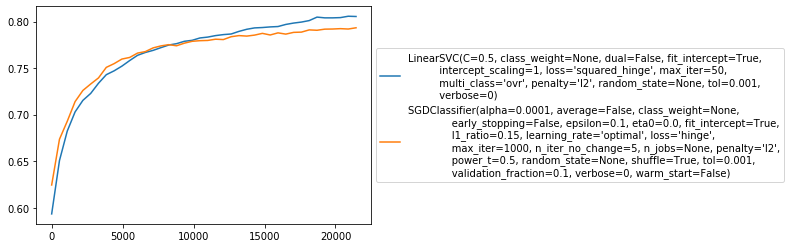

In [26]:
#At first I wanted to use this to compare different models, but some of them were taking a lot of time to fit
# So I decided to only use SGD and LinearSVC as they were fitting quickly and giving best results
def plot_score(arr, train, train_res, test, test_res):
    res = {}
    step = 550
    points = [0 for z in range(int(22000/step))]
    for x in arr:
        res[x] = [0 for z in range(int(22000/step))]
    for i in range(0, 22000, step):
        for x in arr:
            x.fit(train[:i+step], train_res[:i+step])
            res[x][int(i/step)] = x.score(test, test_res)
        points[int(i/step)] = i
    for z in arr:
        plt.plot(points, res[z], label=z)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    #testing some different classifiers
plot_score([LinearSVC(penalty='l2', loss='squared_hinge', dual=False, tol=1e-3, C=0.5, max_iter=50), 
            SGDClassifier()
            ]
           , train_set, train_set_1_result, train_set_2, train_set_2_result)

In [53]:
# tried also those models but didn't achieve any good results.
clf = Lasso(alpha=0.005, max_iter=50)
clf.fit(X[0:22500], train_set_1_result)
print("Lasso: {}".format(clf.score(X[22500:30000], train_set_2_result)))

clf = MultinomialNB()
clf.fit(X[0:22500], train_set_1_result)
print("Multinomial: {}".format(clf.score(X[22500:30000], train_set_2_result)))

Lasso: 0.356749995102018
Multinomial: 0.7258666666666667


In [58]:
#My Solution on kaggle was generated here
clf = LinearSVC()
clf.fit(train_set, [encode_cuisine(x) for x in df['cuisine']])
res = clf.predict(test_set)
res = [decode_cuisine(x) for x in res]
result = pd.DataFrame()
result['Id'] = testset['id']
result['cuisine'] = res
result.to_csv("wynik.csv", index=False, header=True)



In [9]:
#I also tried NN but didn't get good enough results.
class NeuralNet(nn.Module):
    def __init__(self, input, first, second, result):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input, first)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(first, second)
        self.layer3 = nn.Linear(second, result)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x =  self.softmax(x)
        return x

In [10]:
# Training settings, low batch sizes or else graphic card refuses to work with me
batch_size = 32
test_batch_size = 32
epochs = 10
lr = 0.01
momentum = 0.5
seed = 1
log_interval = 300
save_model = True
use_cuda = True # change to False if running without GPU

In [11]:
torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 0, 'pin_memory': False} if use_cuda else {}

In [12]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss_f = nn.CrossEntropyLoss(reduction='sum')
        loss = loss_f(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    loss_f = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_f(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
class TrainClass(torchdata.Dataset):
    def __init__(self, ingredients, cuisine, device):
        self.ingredients = torch.tensor(ingredients, dtype=torch.float32).to(device)
        self.ingredients.unsqueeze(0)
        self.cuisine = torch.tensor(cuisine, dtype=torch.int64).to(device)
        print(type(self.ingredients))
        print(self.cuisine.type)
    def __len__(self):
        return len(self.ingredients)
    
    def __getitem__(self, index):
        ingr, target = self.ingredients[index], self.cuisine[index]
        return ingr, target

In [14]:
train_loader = torchdata.DataLoader(TrainClass(ad.values, data_y, device), batch_size= batch_size, shuffle=True, **kwargs)
model1 = NeuralNet(2866, 5500, 2200, 20).to(device)
optimizer = optim.Adam(model1.parameters())

<class 'torch.Tensor'>
<built-in method type of Tensor object at 0x000001EB80218638>


In [15]:

for epoch in range(1, epochs + 1):
    train(log_interval, model1, device, train_loader, optimizer, epoch)



Train Epoch: 1 [0/30000 (0%)]	Loss: 95.742363
Train Epoch: 1 [9600/30000 (32%)]	Loss: 34.291859
Train Epoch: 1 [19200/30000 (64%)]	Loss: 24.385832
Train Epoch: 1 [28800/30000 (96%)]	Loss: 20.208385
Train Epoch: 2 [0/30000 (0%)]	Loss: 15.276747
Train Epoch: 2 [9600/30000 (32%)]	Loss: 26.666166
Train Epoch: 2 [19200/30000 (64%)]	Loss: 17.548162
Train Epoch: 2 [28800/30000 (96%)]	Loss: 22.677431
Train Epoch: 3 [0/30000 (0%)]	Loss: 5.757170
Train Epoch: 3 [9600/30000 (32%)]	Loss: 9.602034
Train Epoch: 3 [19200/30000 (64%)]	Loss: 4.564411
Train Epoch: 3 [28800/30000 (96%)]	Loss: 15.048946
Train Epoch: 4 [0/30000 (0%)]	Loss: 4.895045
Train Epoch: 4 [9600/30000 (32%)]	Loss: 0.800541
Train Epoch: 4 [19200/30000 (64%)]	Loss: 12.277529
Train Epoch: 4 [28800/30000 (96%)]	Loss: 2.216686
Train Epoch: 5 [0/30000 (0%)]	Loss: 5.875245
Train Epoch: 5 [9600/30000 (32%)]	Loss: 1.995206
Train Epoch: 5 [19200/30000 (64%)]	Loss: 3.323294
Train Epoch: 5 [28800/30000 (96%)]	Loss: 9.437392
Train Epoch: 6 [0/30

In [16]:
x = Variable(torch.from_numpy(testdf.values[0:4774]).to(device)).float()
y_pred = model1(x)
y_pred

tensor([[-37.1142, -46.7480, -44.4376,  ..., -27.5402, -40.8777, -46.1751],
        [ -0.1566, -10.1664, -10.0039,  ...,  -7.1329,  -3.9872,  -8.3023],
        [-25.1073, -14.7559, -17.8871,  ..., -15.8472, -20.8948, -21.7334],
        ...,
        [-63.3316, -58.7054, -64.8245,  ..., -57.6128, -36.9036, -29.7913],
        [-10.6061, -11.3544, -13.6310,  ..., -10.5706, -18.6609, -11.7136],
        [-23.1772, -15.6801, -30.0379,  ..., -35.0795,  -0.4896, -16.8961]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [17]:
x2 = Variable(torch.from_numpy(testdf.values[4774:9774]).to(device)).float()
y_pred2 = model1(x2)

In [18]:
duo = torch.cat((y_pred, y_pred2), dim=0)
print(duo.shape)
print(y_pred.shape)
print(y_pred2.shape)
print(testset.shape)


torch.Size([9774, 20])
torch.Size([4774, 20])
torch.Size([5000, 20])
(9774, 2)


In [19]:
pred = duo.argmax(dim=1)

In [20]:
#result is ~0.784 so that's not good enough
encoded = np.array(pred.cpu())
encoded = [decode_cuisine(x) for x in encoded]
result = pd.DataFrame()
result['Id'] = testset['id']
result['cuisine'] = encoded
result.to_csv("nn_wynik.csv", index=False, header=True)


